# Using Bio-Signals to Predict Smoker Status
#### By Jai Rastogi

Member 1: Jai Rastogi, Contribution: 100%

We, all team members, agree together that the above information is true, and we are confident about our contributions to this submitted project/final tutorial.

Jai Rastogi, 05/07/24

I did everything by myself, since I worked alone.

## Introduction

According to the [Center for Disease Control](https://www.cdc.gov/tobacco/data_statistics/fact_sheets/adult_data/cig_smoking/index.htm), cigarette smoking is the leading cause of preventable deaths in the US, leading to 480 thousand deaths each year. Out of an estimated 28.3 million adults who currently smoke, over 16 million of them have a smoking-related disease. Furthermore, the [CDC](https://www.cdc.gov/policy/polaris/healthtopics/tobacco/index.html) also states that treating these illnesses costs over \$225 billion dollars and leads to over \$156 billion dollars in lost productivity each year, which is a major economic loss. However, a [UK study](https://www.directlinegroup.co.uk/en/news/brand-news/2020/secret-smokers--nearly-half-of-smokers-hide-their-habits.html) suggests that 20% of smokers don't tell or give misleading information to their medical practitioners about their smoking habits. This leads to higher chances of forming a smoking-related illness and significant economical ramifications. So, I chose the [Smoker Status Prediction through Biosignals](https://www.kaggle.com/datasets/gauravduttakiit/smoker-status-prediction-using-biosignals) dataset for this project to determine how well medical professionals can predict a person's smoking status based on solely their chemical signals. This is important because they can screen smokers for any smoking-related disease before their condition becomes bad, and early detection can save people and companies millions, if not billions, of dollars.  

I decided on using this dataset because it provides over 55,000 rows of biological data, including bio-signals like the levels of individual hormones and proteins, about both smokers and non-smokers. The primary questions I am trying to answer are:
* Are there any strong trends or clusters between a specific combination of bio-signals and smoking?
* What models best ensure that all smokers are identified?

## Data Preprocessing

This code installs and imports all the necessary packages.

In [1]:
!pip install factor_analyzer
!pip install umap-learn

In [2]:
import numpy as np
from numpy import mean
from numpy import unique
from numpy import where
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity, calculate_kmo
from prettytable import PrettyTable
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, f1_score, roc_auc_score, silhouette_score, precision_recall_curve, PrecisionRecallDisplay
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import umap
import warnings

pd.options.display.max_columns = None
plt.style.use("ggplot")
warnings.filterwarnings('ignore')

This code loads in the datasets, which were already split. However, since the dataset "test_dataset.csv" does not contain the 'smoking' attribute, it cannot be used for testing how well the ML model performs, and will only be used for unsupervised learning. Since there are two datasets, there exists the possibility that there exist duplicate rows within and across the datasets. This following code block removes rows that are duplicated in the same dataset.

In [3]:
sup_df = pd.read_csv('train_dataset.csv')
unsup_df = pd.read_csv('test_dataset.csv')

sup_df = sup_df.drop_duplicates()
unsup_df = unsup_df.drop_duplicates()

sup_df.info()
print("\n\n")
unsup_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 33467 entries, 0 to 38983
Data columns (total 23 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   age                  33467 non-null  int64  
 1   height(cm)           33467 non-null  int64  
 2   weight(kg)           33467 non-null  int64  
 3   waist(cm)            33467 non-null  float64
 4   eyesight(left)       33467 non-null  float64
 5   eyesight(right)      33467 non-null  float64
 6   hearing(left)        33467 non-null  int64  
 7   hearing(right)       33467 non-null  int64  
 8   systolic             33467 non-null  int64  
 9   relaxation           33467 non-null  int64  
 10  fasting blood sugar  33467 non-null  int64  
 11  Cholesterol          33467 non-null  int64  
 12  triglyceride         33467 non-null  int64  
 13  HDL                  33467 non-null  int64  
 14  LDL                  33467 non-null  int64  
 15  hemoglobin           33467 non-null  floa

There are no null values in either dataset, so no imputation is necessary.

The following code block deals with rows that are duplicated between the supervised and unsupervised datasets. Specifically, the copy is removed from the supervised dataset. This is because a ML model will be trained through supervised learning techniques, and it would be beneficial to have more training data.

In [4]:
# Drop rows that are duplicated between the given supervised and unsupervised learning datasets

df_merge = pd.merge(sup_df, unsup_df, how='inner')
merged = pd.concat([unsup_df, df_merge])

features_lst = list(set(sup_df.columns) - set(['smoking']))

merged['Duplicated'] = merged.duplicated(subset=features_lst, keep=False)

print("Number of duplicated rows between the unsupervised and supervised datasets: ", (merged['Duplicated'].sum() / 2), "\n\n")

unsup_df = merged[~merged['Duplicated']]
del unsup_df['Duplicated']
del unsup_df['smoking'] # 0 values in this column

sup_df.info()
print("\n\n")
unsup_df.info()

Number of duplicated rows between the unsupervised and supervised datasets:  4625.0 


<class 'pandas.core.frame.DataFrame'>
Index: 33467 entries, 0 to 38983
Data columns (total 23 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   age                  33467 non-null  int64  
 1   height(cm)           33467 non-null  int64  
 2   weight(kg)           33467 non-null  int64  
 3   waist(cm)            33467 non-null  float64
 4   eyesight(left)       33467 non-null  float64
 5   eyesight(right)      33467 non-null  float64
 6   hearing(left)        33467 non-null  int64  
 7   hearing(right)       33467 non-null  int64  
 8   systolic             33467 non-null  int64  
 9   relaxation           33467 non-null  int64  
 10  fasting blood sugar  33467 non-null  int64  
 11  Cholesterol          33467 non-null  int64  
 12  triglyceride         33467 non-null  int64  
 13  HDL                  33467 non-null  int64  
 14  LDL 

Here, feature engineering is performed by adding four more characteristics, so that there are potentially more differences for a ML model to determine. These characteristics are easily calculated by doing basic mathematical operations on the original datasets, and have a broader meaning in the field of biology.

* BMI refers to the body mass index, which measures body fat based on height and weight.
* The Blood Pressure Difference refers to the difference between the Systolic and Relaxation Blood Pressures, which is the Pulse Pressure.
* The HDL-LDL ratio refers to HDL (high-density lipoprotein) cholesterol divided by LDL (low-density lipoprotein) cholesterol. This can be significant because research experiments have found [links](https://www.healthline.com/health/smoking-and-cholesterol#heart-attack-risk:~:text=lung%20cancer-,Beyond,-the%20impact%20on) between smoking, and lower HDL levels and higher LDL levels.
* The Liver Enzyme Ratio refers to the ratio between AST (Aspartate aminotransferase) and ALT (alanine aminotransferase). This ratio helps medical professionals diagnose liver injuries, and smoking is known to impact the liver.

Then, the supervised learning dataset is split into the train and test datasets.

In [5]:
def bmi(x):
  return x['weight(kg)'] / ((x['height(cm)'] / 100) ** 2)

def bp_diff(x):
  return x['systolic'] - x['relaxation']

def hdl_ldl_ratio(x):
  return x['HDL'] / x['LDL']

def liver_enzyme_ratio(x):
  return x['AST'] / x['ALT']

sup_df['BMI'] = sup_df.apply(lambda x : bmi(x), axis=1)
unsup_df['BMI'] = unsup_df.apply(lambda x : bmi(x), axis=1)

sup_df['BP Diff'] = sup_df.apply(lambda x : bp_diff(x), axis=1)
unsup_df['BP Diff'] = unsup_df.apply(lambda x : bp_diff(x), axis=1)

sup_df['HDL-LDL Ratio'] = sup_df.apply(lambda x : hdl_ldl_ratio(x), axis=1)
unsup_df['HDL-LDL Ratio'] = unsup_df.apply(lambda x : hdl_ldl_ratio(x), axis=1)

sup_df['Liver Enzyme Ratio'] = sup_df.apply(lambda x : liver_enzyme_ratio(x), axis=1)
unsup_df['Liver Enzyme Ratio'] = unsup_df.apply(lambda x : liver_enzyme_ratio(x), axis=1)

X_train, X_test, y_train, y_test = train_test_split(sup_df.loc[:, sup_df.columns != 'smoking'], sup_df['smoking'], test_size=0.30, random_state=25)

## Exploratory Data Analysis: Statistical Method #1
It must be determined whether the given train and test datasets have similar trends to each other. If the test dataset is not representative of the train dataset, the machine learning model would be evaluated on data with different trends than what it was trained with, resulting in the model having poorly trained hyperparameters, low precision and recall, and poor robustness.

In [6]:
def abline(slope, intercept):
    """Plot a line from slope and intercept"""
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, '--', color='k')

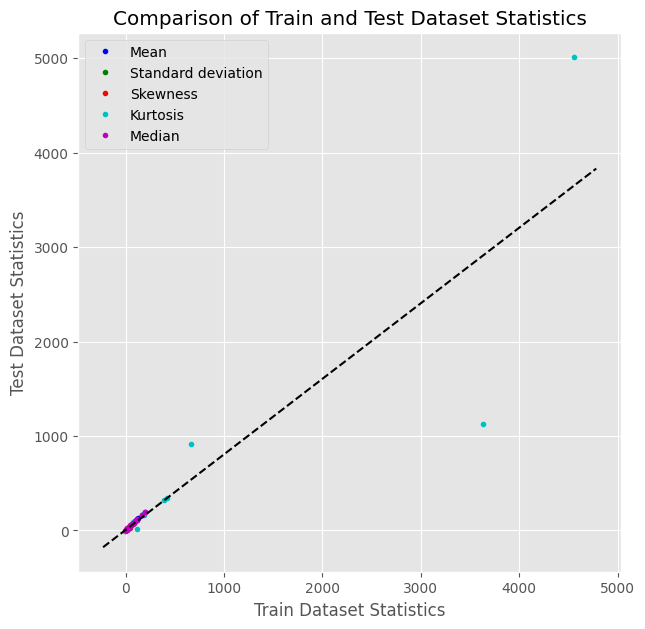

Pearson correlation coefficient:  0.8974503625592569


In [7]:
features_lst = list(set(sup_df.columns) - set(['smoking']))

plt.figure(figsize=(7, 7))

train_pts_lst = pd.concat([X_train[features_lst].mean(), X_train[features_lst].std(),
                          X_train[features_lst].skew(), X_train[features_lst].kurtosis(),
                          X_train[features_lst].median()]).tolist()

test_pts_lst = pd.concat([X_test[features_lst].mean(), X_test[features_lst].std(),
                          X_test[features_lst].skew(), X_test[features_lst].kurtosis(),
                          X_test[features_lst].median()]).tolist()

slope, intercept, r_value, p_value, std_err = stats.linregress(train_pts_lst, test_pts_lst)

plt.plot(X_train[features_lst].mean(), X_test[features_lst].mean(), 'b.', label='Mean')
plt.plot(X_train[features_lst].std(), X_test[features_lst].std(), 'g.', label='Standard deviation')
plt.plot(X_train[features_lst].skew(), X_test[features_lst].skew(), 'r.', label='Skewness')
plt.plot(X_train[features_lst].kurtosis(), X_test[features_lst].kurtosis(), 'c.', label='Kurtosis')
plt.plot(X_train[features_lst].median(), X_test[features_lst].median(), 'm.', label='Median')

abline(slope, intercept)

plt.title('Comparison of Train and Test Dataset Statistics')
plt.xlabel('Train Dataset Statistics')
plt.ylabel('Test Dataset Statistics')

plt.legend()

plt.show()

print('Pearson correlation coefficient: ', r_value)

Since the Pearson Correlation Coefficient of this linear regression is 0.8975, there is a strong positive trend between the test and train data statistics. Therefore, the test dataset can be used to test the accuracy and efficacy of the machine learning model.

## Exploratory Data Analysis: Statistical Method #2
In order to see if a machine learning model can find trends in the biomarkers between smokers and non-smokers, there needs to exist some set of differences between the two groups for at least one characteristic. So, before performing the statistical tests, a violin plot of each characteristic, grouped by smoking status, is displayed to compare the distributions.

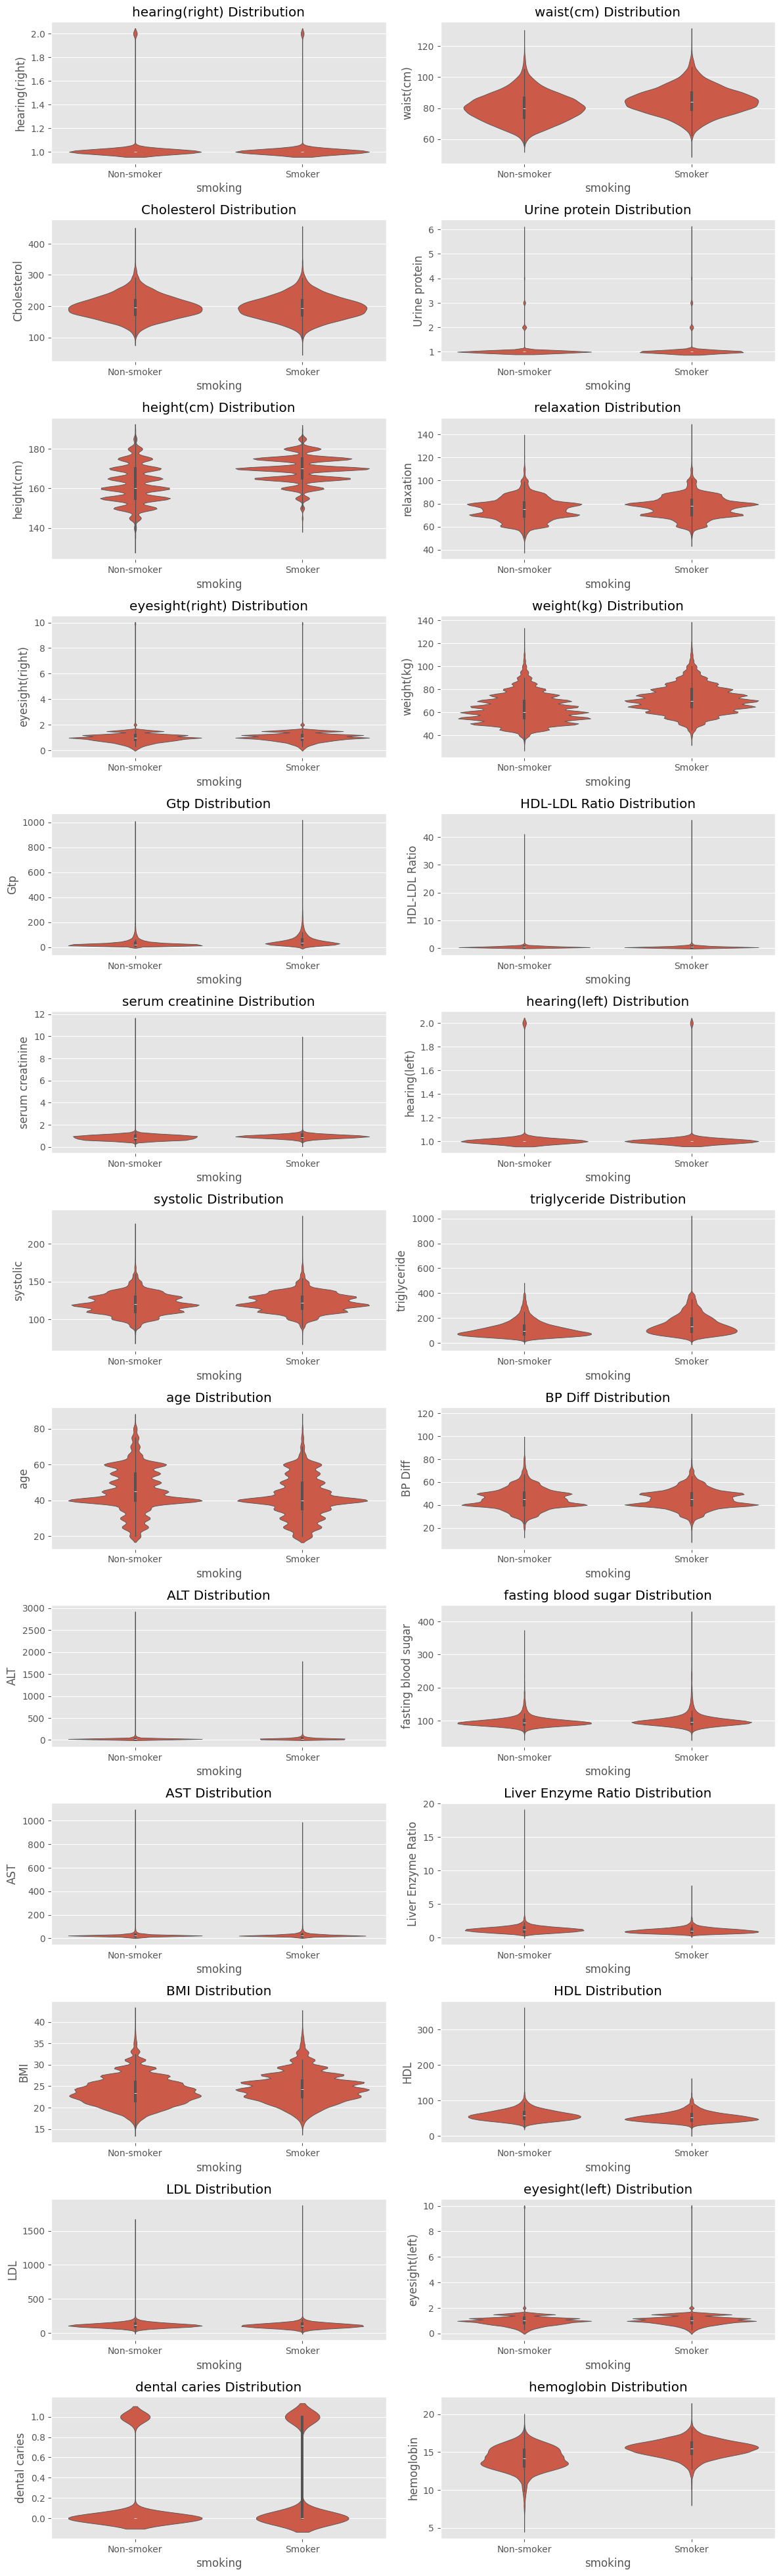

In [8]:
num_rows = len(features_lst)
num_cols = 2

total_plots = num_rows * num_cols
plt.figure(figsize=(12, num_rows * 3))

for idx, col in enumerate(features_lst):
    plt.subplot(num_rows, num_cols, idx % total_plots + 1)
    sns.violinplot(x=sup_df['smoking'], y=col, data=sup_df)
    plt.title(f"{col} Distribution")
    plt.xticks(ticks=[0, 1], labels=['Non-smoker', 'Smoker'])

plt.tight_layout()
plt.show()

There are some characteristics where there is visibly a difference in the distribution between smokers and non-smokers from the graphs, namely:
* Height
* Weight
* Waist size
* Triglycerides
* Hemoglobin

More formally, a two sample T Test can be conducted for each attribute to determine if the difference in means is significant. That is, for each characteristic:

* *H0*: the mean of the characteristic is the same between the group of non-smokers and smokers.

* *HA*: the mean of the characteristic is different between the group of non-smokers and smokers.

The following code conducts the hypothesis test for each characteristic and prints the resulting p values.

In [9]:
t = PrettyTable(['Column', 'P Value', 'Statistically Significant'])

for idx, col in enumerate(features_lst):
  non_smokers = sup_df[sup_df['smoking'] == 0][col].tolist()
  smokers = sup_df[sup_df['smoking'] == 1][col].tolist()

  no_var = np.var(non_smokers)
  yes_var = np.var(smokers)

  if max(no_var, yes_var) / min(no_var, yes_var) <= 4:
    stat, p_val = stats.ttest_ind(a=non_smokers, b=smokers, equal_var=True)
    t.add_row([col, p_val, (p_val < 0.05)])
  else:
    stat, p_val = stats.ttest_ind(a=non_smokers, b=smokers, equal_var=False)
    t.add_row([col, p_val, (p_val < 0.05)])
print(t)

+---------------------+-------------------------+---------------------------+
|        Column       |         P Value         | Statistically Significant |
+---------------------+-------------------------+---------------------------+
|    hearing(right)   |  0.0009528654736707336  |            True           |
|      waist(cm)      |           0.0           |            True           |
|     Cholesterol     |  6.219730630816252e-08  |            True           |
|    Urine protein    |   0.01400224800170272   |            True           |
|      height(cm)     |           0.0           |            True           |
|      relaxation     |  7.427215487273338e-82  |            True           |
|   eyesight(right)   |  7.371407554543046e-30  |            True           |
|      weight(kg)     |           0.0           |            True           |
|         Gtp         |           0.0           |            True           |
|    HDL-LDL Ratio    |  0.0035712350534958734  |            Tru

The value of $\alpha$ used in these hypothesis tests is $0.05$. The p value for the two sample T Test is less than
 for every characteristic apart from 'BP Diff', or the difference between the Systolic and Relaxation Blood Pressures. Therefore, there is a statistically significant difference between the means of each characteristic, apart from Blood Pressure Difference, when compared between non-smokers and smokers. This means that there exist many markers that the ML model can utilize to predict if a person is a smoker or non-smoker, based on solely biomarker data.

## Exploratory Data Analysis: Statistical Method #3
Another important thing to note is how each characteristic correlates to each other, and if characteristics can be removed without the loss of information. So, correlation heatmaps are calculated for both the train and test datasets, some non-obvious correlations are examined, and a few tests are run.

Text(0.5, 1.0, 'Correlation Heatmap for Train Dataset')

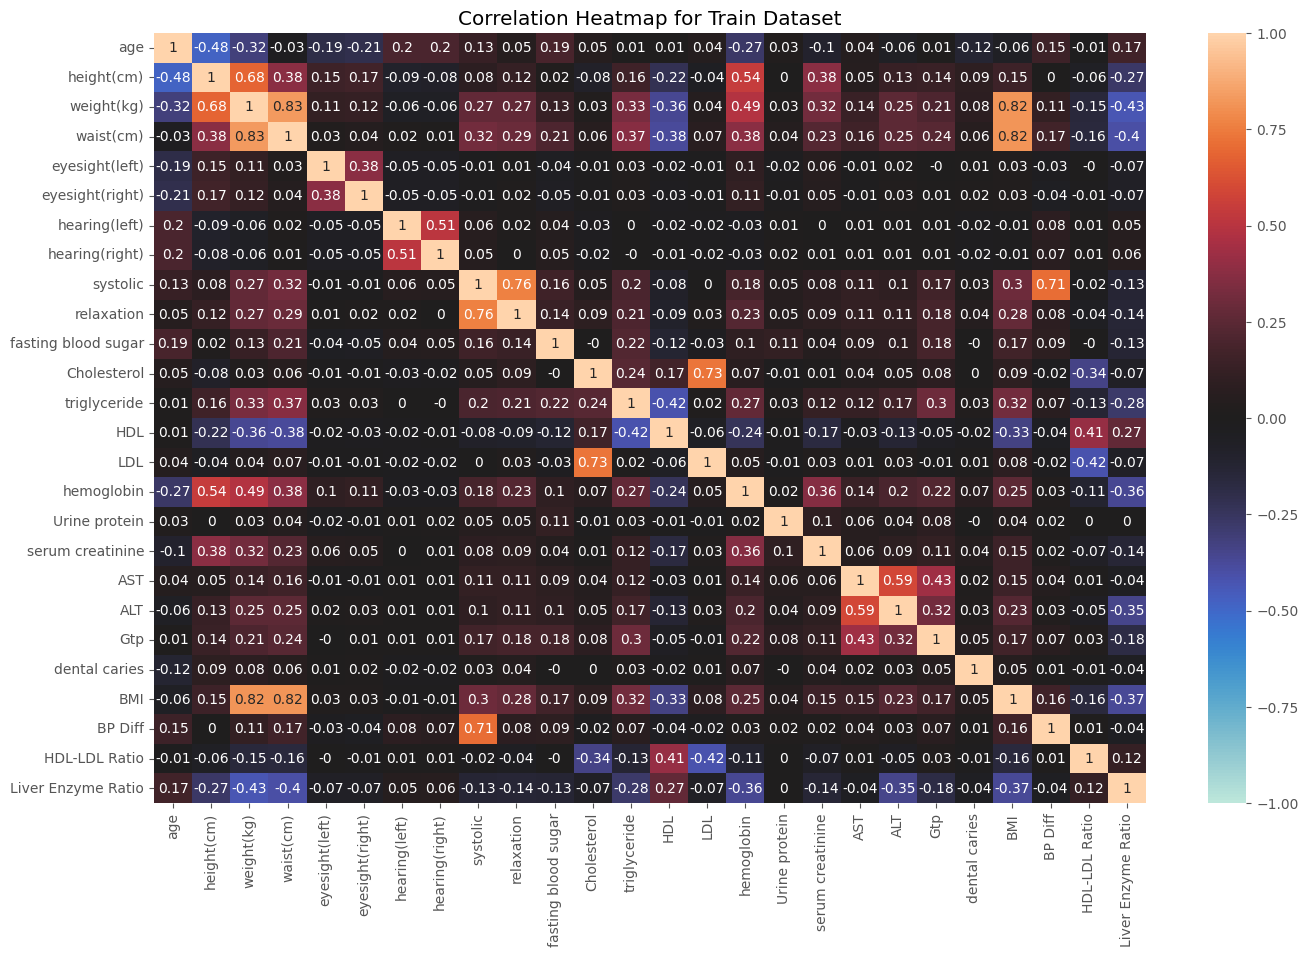

In [10]:
fig, ax = plt.subplots(figsize=(16,10))
train_corr = X_train.corr().round(2)
sns.heatmap(train_corr, annot=True, ax=ax, vmin=-1, vmax=1, center=0)
ax.set_title("Correlation Heatmap for Train Dataset")

There are some moderately strong correlations between two characteristics. Some of these are expected because the data points measure similar attributes of the person. Examples include the following:
* Left and right eyesight
* Left and right hearing
* Cholesterol and LDL (LDL is a type of cholesterol)
* AST and ALT (both are liver enzymes)

There are also some correlations that aren't immediately obvious, as such as those graphed below:


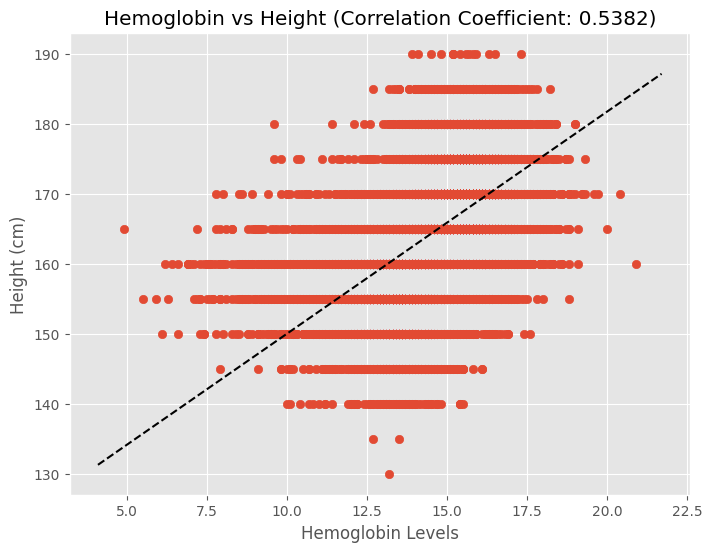

In [11]:
hemo_height_corr_coeff = X_train['hemoglobin'].corr(X_train['height(cm)'])

plt.figure(figsize=(8, 6))
plt.scatter(X_train['hemoglobin'], X_train['height(cm)'])
plt.xlabel('Hemoglobin Levels')
plt.ylabel('Height (cm)')
plt.title(f'Hemoglobin vs Height (Correlation Coefficient: {hemo_height_corr_coeff:.4f})')
plt.grid(True)

slope, intercept, r_value, p_value, std_err = stats.linregress(X_train['hemoglobin'].tolist(), X_train['height(cm)'].tolist())
abline(slope, intercept)

plt.show()

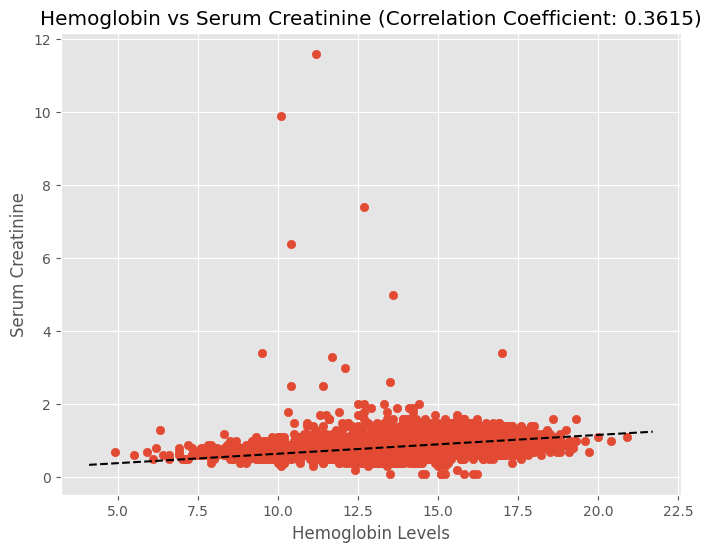

In [12]:
hemo_serum_corr_coeff = X_train['hemoglobin'].corr(X_train['serum creatinine'])

plt.figure(figsize=(8, 6))
plt.scatter(X_train['hemoglobin'], X_train['serum creatinine'])
plt.xlabel('Hemoglobin Levels')
plt.ylabel('Serum Creatinine')
plt.title(f'Hemoglobin vs Serum Creatinine (Correlation Coefficient: {hemo_serum_corr_coeff:.4f})')
plt.grid(True)

slope, intercept, r_value, p_value, std_err = stats.linregress(X_train['hemoglobin'].tolist(), X_train['serum creatinine'].tolist())
abline(slope, intercept)

plt.show()

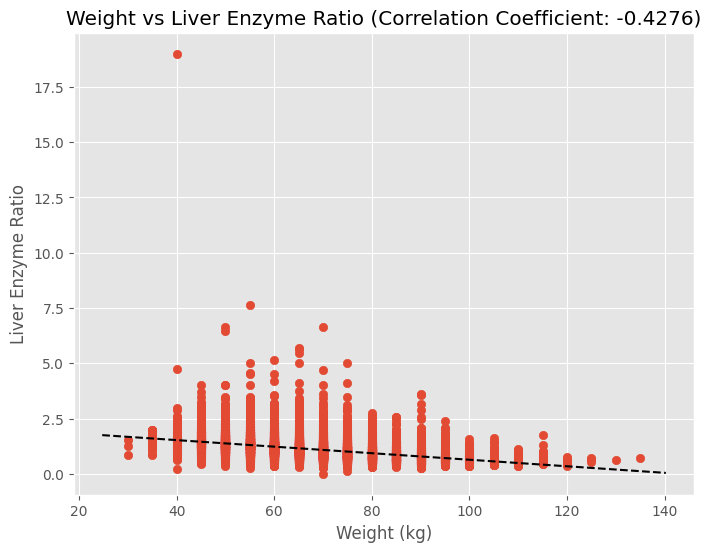

In [13]:
hemo_serum_corr_coeff = X_train['weight(kg)'].corr(X_train['Liver Enzyme Ratio'])

plt.figure(figsize=(8, 6))
plt.scatter(X_train['weight(kg)'], X_train['Liver Enzyme Ratio'])
plt.xlabel('Weight (kg)')
plt.ylabel('Liver Enzyme Ratio')
plt.title(f'Weight vs Liver Enzyme Ratio (Correlation Coefficient: {hemo_serum_corr_coeff:.4f})')
plt.grid(True)

slope, intercept, r_value, p_value, std_err = stats.linregress(X_train['weight(kg)'].tolist(), X_train['Liver Enzyme Ratio'].tolist())
abline(slope, intercept)

plt.show()

Clearly, there are a few moderately strong correlations between characteristics.

The correlations on the test dataset can also be checked to further ensure that it is representative of the data in the train dataset.

Text(0.5, 1.0, 'Correlation Heatmap for Test Dataset')

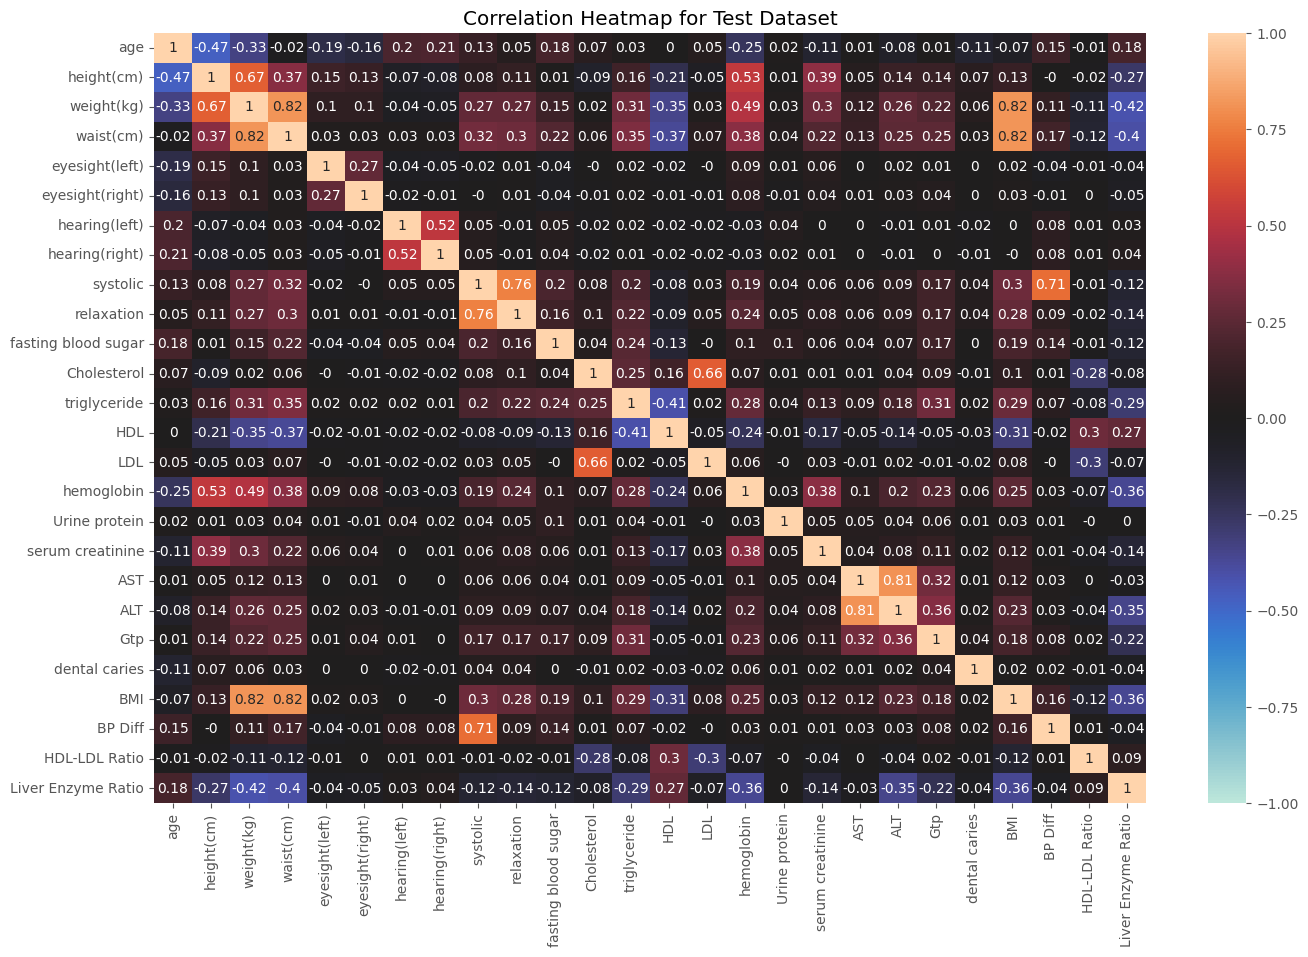

In [14]:
fig, ax = plt.subplots(figsize=(16,10))
test_corr = X_test.corr().round(2)
sns.heatmap(test_corr, annot=True, ax=ax, vmin=-1, vmax=1, center=0)
ax.set_title("Correlation Heatmap for Test Dataset")

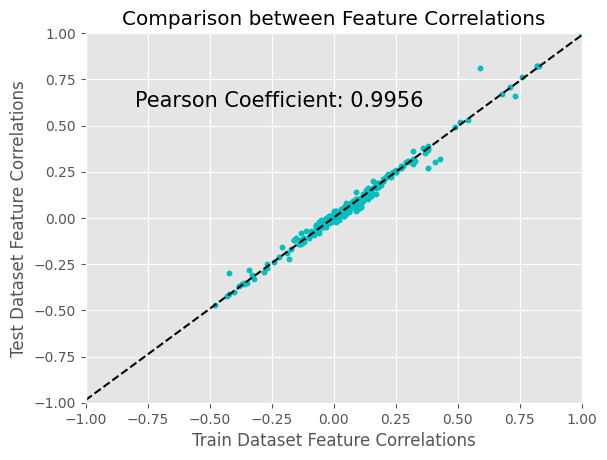

In [15]:
train_corr_lst = np.array(train_corr).flatten()
test_corr_lst = np.array(test_corr).flatten()

plt.plot(train_corr_lst, test_corr_lst, 'c.')
plt.xlim(-1, 1)
plt.ylim(-1, 1)

slope, intercept, r_value, p_value, std_err = stats.linregress(train_corr_lst, test_corr_lst)
abline(slope, intercept)

text = 'Pearson Coefficient: ' + str(np.round(r_value, decimals=4))
plt.text(-.8, .6, text, fontsize = 15)

plt.xlabel('Train Dataset Feature Correlations')
plt.ylabel('Test Dataset Feature Correlations')

plt.title('Comparison between Feature Correlations')

plt.show()

Since the Pearson Correlation Coefficient of each correlation between the train and test dataset is 0.9956, there is a nearly perfect linear relationship between the correlations. This further supports the statement that the test dataset represents the same trends as the train dataset.

Furthermore, a factor analysis can be performed on the train dataset to determine if the dataset dimension can be reduced without a loss of information. Specifically, Bartlett’s test of sphericity and the Kaiser-Meyer-Olkin (KMO) Test will be conducted to calculate the statistical significance of performing data reduction.

For Bartlett's test of sphericity:
* *H0*: The correlation matrix of the train dataset is an identity matrix.
* *HA*: The correlation matrix of the train dataset is not an identity matrix.


In [16]:
chi_square_value, p_value = calculate_bartlett_sphericity(train_corr)
print("The p-value of Bartlett's Test of Sphericity: ", p_value)

The p-value of Bartlett's Test of Sphericity:  6.055537005483194e-90


Since $6.056*10^{-90} < \alpha = 0.05$, the test is statistically significant and the null hypothesis can be rejected: the correlation matrix is not an identity matrix. The KMO Test can then be performed to determine how suitable the correlation matrix is for feature analysis.

In [17]:
kmo_all, kmo_model = calculate_kmo(X_train)
print("KMO all: \n", kmo_all, "\n\n\nKMO value: ", kmo_model)

KMO all: 
 [0.79726555 0.45082426 0.61530583 0.95252721 0.65170414 0.66913465
 0.57826266 0.57444141 0.43779779 0.34820175 0.83833109 0.39235128
 0.58478121 0.52072623 0.47742892 0.92915508 0.66799965 0.89879105
 0.57864329 0.66829067 0.81503058 0.83627782 0.53264783 0.24071078
 0.6397012  0.8255937 ] 


KMO value:  0.5719915519584304


The KMO value of $0.5720$ indicates that while a few features share correlations, it is not appropriate to perform factor analysis. As a result, no features will be merged together.

The same technique of determining how well two datasets correlate to each other can be applied to the given supervised and unsupervised learning datasets.

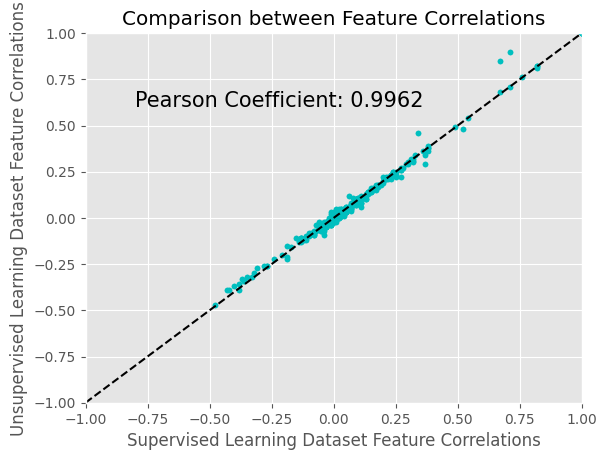

In [18]:
sup_corr = sup_df.loc[:, sup_df.columns !='smoking'].corr().round(2)
unsup_corr = unsup_df.loc[:, unsup_df.columns !='smoking'].corr().round(2)

sup_corr_lst = np.array(sup_corr).flatten()
unsup_corr_lst = np.array(unsup_corr).flatten()

plt.plot(sup_corr_lst, unsup_corr_lst, 'c.')
plt.xlim(-1, 1)
plt.ylim(-1, 1)

slope, intercept, r_value, p_value, std_err = stats.linregress(sup_corr_lst, unsup_corr_lst)
abline(slope, intercept)

text = 'Pearson Coefficient: ' + str(np.round(r_value, decimals=4))
plt.text(-.8, .6, text, fontsize = 15)

plt.xlabel('Supervised Learning Dataset Feature Correlations')
plt.ylabel('Unsupervised Learning Dataset Feature Correlations')

plt.title('Comparison between Feature Correlations')

plt.show()

Since the Pearson Correlation Coefficient of each correlation between the supervised learning and unsupervised learning dataset is 0.9962, there is a nearly perfect linear relationship between the correlations. So, the unsupervised learning dataset represents the same trends as the supervised learning dataset.

## Overall Conclusions from Exploratory Data Analysis

There is a significant amount of continuous data that will be used to predict a categorical variable, so a machine learning algorithm for classification will be used. For running the algorithm, the train dataset can be split up into train and validation datasets, and the test dataset can be used as is to test the model during training. This is because according to statistical methods #1 and #3, the given train and test datasets are very similar to each other.

Based on the results of statistical method #2, an ML algorithm can be very effective because there is a significant difference in the mean of each characteristic (except for the Blood Pressure Difference) between the smokers and non-smokers. Moreover, based on the plots, there are many outliers for a lot of characteristics. It is not useful to remove them, since they indicate an abnormal reading that may imply the presence of a certain disease or injury that the general population doesn't have. That affliction may be related to the person being a smoker. It is true that some outliers could be from faulty measurement tools, but in medicine, the instruments are very precise and used carefully to be as accurate as possible. So, outliers are not removed and log transforms will be necessary to normalize skewed characteristic distributions in the feature engineering step.

Based on the results of statistical method #3, there are a few pairs of characteristics that are moderately correlated to each other, but there are not many of these. The majority of the pairs of characteristics have little to no correlation, and the Kaiser-Meyer-Olkin Test confirms that feature analysis is not necessary because there aren't enough common variances between the features.Furthermore, the data instances from the unsupervised learning dataset are very similar to those in the supervised learning dataset, which suggests that these two sets of data can be combined to run unsupervised learning algorithms.

## Machine Learning and Visualization

We wish to apply machine learning models to predict smoker status from these biosignals, and see how well each model performs on this dataset. Broadly speaking, machine learning (ML) algorithms learn trends and features from data over time. There are three broad subsets of ML: supervised learning, unsupervised learning, and reinforcement learning. In supervised learning, the models can directly learn how the features relate to the target variable, whether that is a label (in classification) or a value (in regression). In unsupervised learning, there is no target variable, so the models find hidden patterns and insights in the data. In reinforcement learning, models are trained to optimize decisions for specific situations, rather than predicting a target variable. In this tutorial, I will use supervised and unsupervised learning models to answer my questions.

The three supervised learning models that I will use are Logistic Regression, Random Forests, and Balanced Random Forests.

* [Logistic Regression](https://www.geeksforgeeks.org/understanding-logistic-regression/) is a classification algorithm used for binary classification, or YES/NO problems. It takes a set of input features $X$, applies a weight $\alpha_i$ for the importance of each feature $X_i$, say $z = \alpha_1X_1 + \dots + \alpha_nX_n$, and applies the logistic sigmoid function $sigmoid(z) = \frac{1}{1 + e^{-z}}$ to the linear combination to predict the probability that the output label is 1 (or YES). The weights $\alpha$ are tuned through optimization algorithms, such as Gradient Descent, that minimize the logistic loss function, or the error between the predicted probability and the expected target variable label. It is implemented in the sklearn library.
* The [Random Forest](https://www.ibm.com/topics/random-forest) model is a classification and regression algorithm that improves on the Decision Tree model. A Decision Tree contains a series of questions that check if the given row satisfies or doesn't satisfy the given condition, and eventually arrives at a decision (the predicted target variable) for that set of data. A Random Forest performs the ensemble technique of "Bagging" on Decision Trees: it creates $n$ decision trees, which are each trained on a random subset of the training data (selected with replacement). $n$ is a hyperparameter. When predicting the target variable in the classification case (what we are using here), all $n$ decision trees give a decision and the Random Forest's final decision is the mode, or the most common class decision, for each row. This model is implemented in the sklearn library.
* The [Balanced Random Forest](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#:~:text=learners%20for%20details.-,class_weight,-%7B%E2%80%9Cbalanced%E2%80%9D%2C%20%E2%80%9Cbalanced_subsample%E2%80%9D%7D%2C%20dict) model modifies the Random Forest model by adding an extra parameter for class weight. Since there are more rows with the non-smoking target attribute than with the smoking target attribute, the two classes will likely be imbalanced when training a ML model. This extra parameter states that the iterative improvement to the model will be weighted based on how much that target attribute shows up in the dataset.


### Results of Adding Features

The first thing to test is to determine if adding four features (Body Mass Index, Blood Pressure Difference, HDL-LDL Ratio, and Liver Enzyme Ratio) in the feature engineering step improves the performance of these ML models. To do so, I iteratively determine the optimal depth of the Random Forest Classifier and Balanced Random Forest Classifier for both sets of data, and evaluate the F1 and ROC-AUC scores.

* The [F1 score](https://www.geeksforgeeks.org/f1-score-in-machine-learning/) calculates the harmonic mean of Precision and Recall. Precision evaluates the presence of false positives (i.e. out of the people classified as smokers, what proportion are actually smokers?). Accuracy evaluates the presence of false negatives (i.e. out of all the actual smokers, what proportion was correctly identified?). The F1 score is between 0 and 1, and a higher F1 score means that the model has higher precision and/or recall.
* The [ROC-AUC score](https://www.evidentlyai.com/classification-metrics/explain-roc-curve) measures how well the model can distinguish between classes. ROC is a probability curve that plots the true positive vs the false positive curve, and AUC represents the area under this curve. A higher ROC-AUC score means that the model can more easily separate the data into a positive and negative class. However, since it only accounts for the number of false positives, it can be inaccurate when there exists a major class imbalance. As a result, the F1 score is more robust, but the ROC-AUC score is still a useful measurement.


Here, I iteratively determine the optimal depth of the Random Forest Classifier and Balanced Random Forest Classifier for the full dataset, including feature engineering, which is 12.

In [19]:
orig_features = ['age', 'height(cm)', 'weight(kg)', 'waist(cm)', 'eyesight(left)',
       'eyesight(right)', 'hearing(left)', 'hearing(right)', 'systolic',
       'relaxation', 'fasting blood sugar', 'Cholesterol', 'triglyceride',
       'HDL', 'LDL', 'hemoglobin', 'Urine protein', 'serum creatinine', 'AST',
       'ALT', 'Gtp', 'dental caries']

In [20]:
def train_rf(X_train_scaled, y_train, X_test_scaled, y_test, start, end):
  for i in range(start, end):
    models = {'Random Forest': RandomForestClassifier(n_estimators=1000, max_depth=i,
                                                      random_state=25, n_jobs=-1),
            'Balanced Random Forest': RandomForestClassifier(n_estimators=1000, max_depth=i,
                                                      random_state=25, n_jobs=-1,
                                                      class_weight="balanced")}

    for model_name, model in models.items():
      model.fit(X_train_scaled, np.ravel(y_train))

    for model_name, model in models.items():
      print("i:", i, "F1", model_name, ":", f1_score(y_test, model.predict(X_test_scaled)))
      print("i:", i, "ROC AUC", model_name, ":", roc_auc_score(y_test, model.predict_proba(X_test_scaled)[:, 1]))
      print(classification_report(y_test, model.predict(X_test_scaled), target_names=['Not smoker', 'Smoker']))

      print("\n")

In [21]:
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train[orig_features])
# X_test_scaled = scaler.transform(X_test[orig_features])

# train_rf(X_train_scaled, y_train, X_test_scaled, y_test, 5, 15)

Here, I iteratively determine the optimal depth of the Random Forest Classifier and Balanced Random Forest Classifier for the full dataset, including feature engineering, which is 13.

In [22]:
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)

# train_rf(X_train_scaled, y_train, X_test_scaled, y_test, 5, 15)

Now, I train both datasets on the tuned ML models, and evaluate which dataset (without the feature augmentation or with it) performs better on the test data. The dataset that yields the higher F1 and ROC-AUC scores overall will be used for the rest of this tutorial. The results are also visualized.

Non-Augmented: 
F1 Logistic Regression : 0.596450392784405
ROC AUC Logistic Regression :  0.8114148971044642
              precision    recall  f1-score   support

  Not smoker       0.76      0.82      0.79      6347
      Smoker       0.64      0.55      0.60      3694

    accuracy                           0.72     10041
   macro avg       0.70      0.69      0.69     10041
weighted avg       0.72      0.72      0.72     10041


F1 Random Forest : 0.6589453604033247
ROC AUC Random Forest :  0.8332292778183299
              precision    recall  f1-score   support

  Not smoker       0.80      0.81      0.80      6347
      Smoker       0.66      0.65      0.66      3694

    accuracy                           0.75     10041
   macro avg       0.73      0.73      0.73     10041
weighted avg       0.75      0.75      0.75     10041


F1 Balanced Random Forest : 0.6985678563309843
ROC AUC Balanced Random Forest :  0.8292407200294739
              precision    recall  f1-score   support

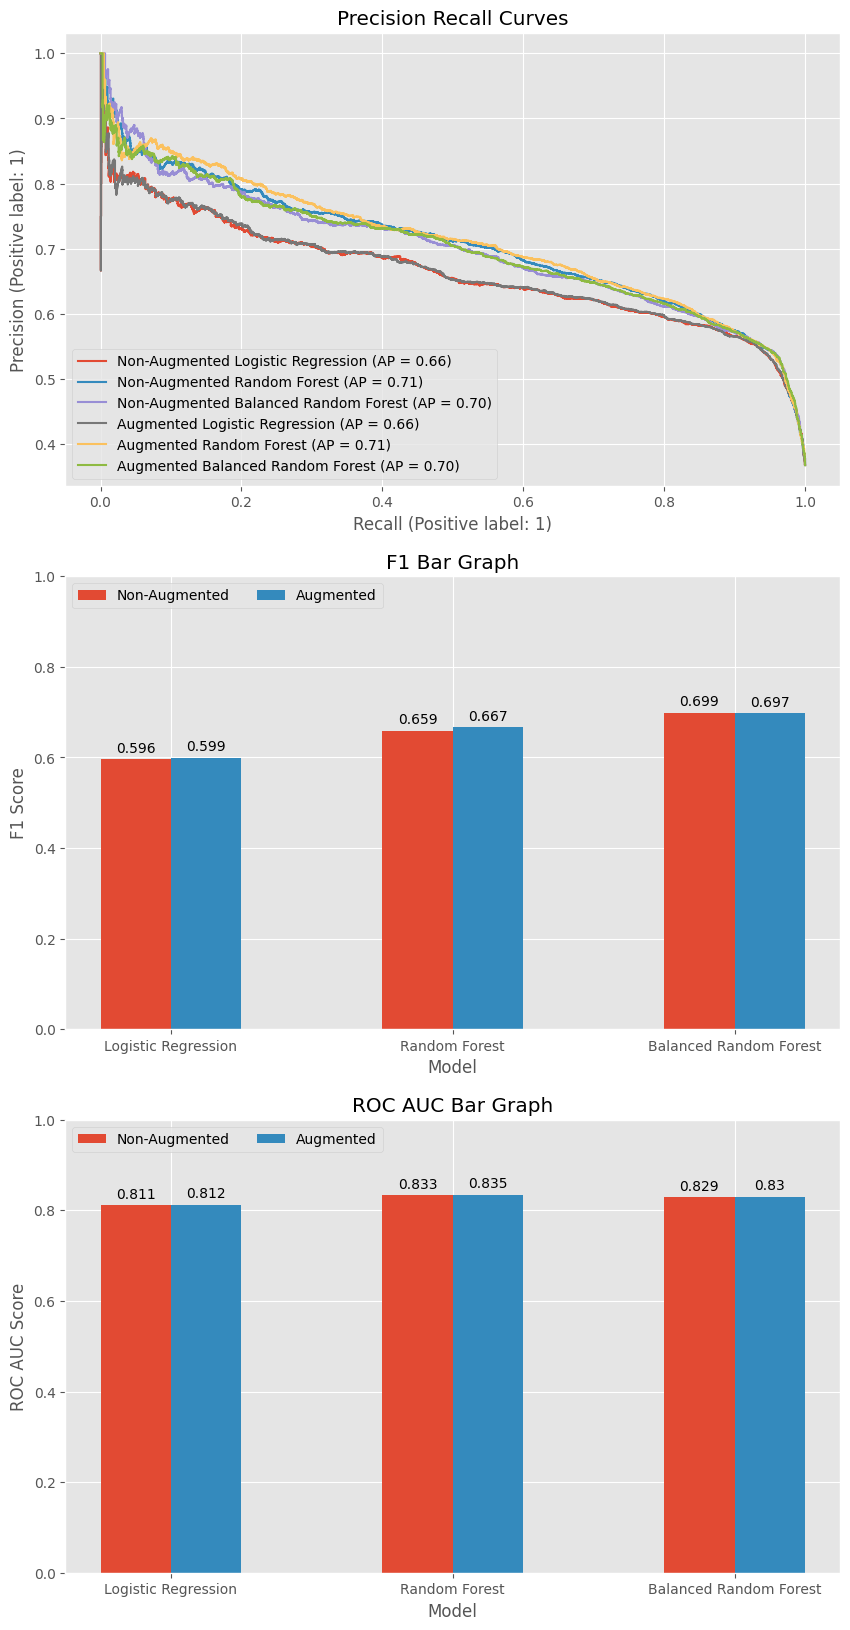

In [23]:
fig, axs = plt.subplots(3, figsize=(10, 20))
axs[0].set_title("Precision Recall Curves")
axs[1].set_title("F1 Bar Graph")
axs[1].set_xlabel('Model')
axs[1].set_ylabel('F1 Score')
axs[2].set_title("ROC AUC Bar Graph")
axs[2].set_xlabel('Model')
axs[2].set_ylabel('ROC AUC Score')
f1_non = []
f1_aug = []
roc_non = []
roc_aug = []
proba_aug = {}
models_aug = {} # Save models on augmented dataset to run later

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[orig_features])
X_test_scaled = scaler.transform(X_test[orig_features])

models = {'Logistic Regression': LogisticRegression(max_iter=1000, random_state=25),
          'Random Forest': RandomForestClassifier(n_estimators=1000, max_depth=12,
                                                  random_state=25, n_jobs=-1),
          'Balanced Random Forest': RandomForestClassifier(n_estimators=1000, max_depth=12,
                                                  random_state=25, n_jobs=-1,
                                                  class_weight="balanced")}

for model_name, model in models.items():
  model.fit(X_train_scaled, np.ravel(y_train))

print("Non-Augmented: ")
for model_name, model in models.items():
  y_predict_proba = model.predict_proba(X_test_scaled)[:, 1]
  y_pred = model.predict(X_test_scaled)
  PrecisionRecallDisplay.from_predictions(y_test, y_predict_proba, ax=axs[0], name=("Non-Augmented " + model_name))

  f1_non.append(f1_score(y_test, y_pred))
  roc_non.append(roc_auc_score(y_test, y_predict_proba))

  print("F1", model_name, ":", f1_score(y_test, y_pred))
  print("ROC AUC", model_name, ": ", roc_auc_score(y_test, y_predict_proba))
  print(classification_report(y_test, y_pred, target_names=['Not smoker', 'Smoker']))
  print()


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

models = {'Logistic Regression': LogisticRegression(max_iter=1000, random_state=25),
          'Random Forest': RandomForestClassifier(n_estimators=1000, max_depth=13,
                                                  random_state=25, n_jobs=-1),
          'Balanced Random Forest': RandomForestClassifier(n_estimators=1000, max_depth=13,
                                                  random_state=25, n_jobs=-1,
                                                  class_weight="balanced")}

for model_name, model in models.items():
  model.fit(X_train_scaled, np.ravel(y_train))

print("\n\nAugmented: ")
for model_name, model in models.items():
  y_predict_proba = model.predict_proba(X_test_scaled)[:, 1]
  y_pred = model.predict(X_test_scaled)
  proba_aug[model_name] = y_predict_proba
  models_aug[model_name] = model
  PrecisionRecallDisplay.from_predictions(y_test, y_predict_proba, ax=axs[0], name=("Augmented " + model_name))

  f1_aug.append(f1_score(y_test, model.predict(X_test_scaled)))
  roc_aug.append(roc_auc_score(y_test, y_predict_proba))

  print("F1", model_name, ":", f1_score(y_test, y_pred))
  print("ROC AUC", model_name, ": ", roc_auc_score(y_test, y_predict_proba))
  print(classification_report(y_test, y_pred, target_names=['Not smoker', 'Smoker']))
  print()


x = np.arange(len(list(models.keys())))
width = 0.25

rects = axs[1].bar(x, np.round(f1_non, decimals=3), width, label=("Non-Augmented"))
axs[1].bar_label(rects, padding=3)

rects = axs[1].bar(x + width, np.round(f1_aug, decimals=3), width, label=("Augmented"))
axs[1].bar_label(rects, padding=3)

axs[1].set_xticks(x + (width / 2), list(models.keys()))
axs[1].legend(loc='upper left', ncols=3)
axs[1].set_ylim(0, 1)

rects = axs[2].bar(x, np.round(roc_non, decimals=3), width, label=("Non-Augmented"))
axs[2].bar_label(rects, padding=3)

rects = axs[2].bar(x+width, np.round(roc_aug, decimals=3), width, label=("Augmented"))
axs[2].bar_label(rects, padding=3)

axs[2].set_xticks(x + (width / 2), list(models.keys()))
axs[2].legend(loc='upper left', ncols=3)
axs[2].set_ylim(0, 1)

plt.show()

Clearly, the models' performance is very similar between both datasets, suggesting that the results of adding these four columns does not harm the ML models' performances. So, for the rest of this tutorial, I will use the full augmented dataset because the extra four features could display some valuable hidden insights.

### Can we do better?

Clearly, the model is able to successfully differentiate between smokers and non-smokers. However, can this be improved? I attempt two approaches:
* Dimensionality Reduction
* Stacking

#### Dimensionality Reduction

In dimensionality reduction, data is transformed from a high-dimensional space (many features) to a low-dimensional space (fewer features) in such a way that the low-dimensional representation still maintains the meaningful trends and properties of the high-dimensional dataset.

In this tutorial, I try two algorithms used for dimensionality reduction: PCA and UMAP.
* [PCA](https://builtin.com/data-science/step-step-explanation-principal-component-analysis), or Principal Component Analysis, linearly transforms the dataset to a new coordinate system of linearly independent Principal Components (vectors), where each axis captures the largest amount of variation in the data. It does this by calculating the covariance matrix for each dimension, calculating the eigenvectors and eigenvalues, and choosing the $k$ largest eigenvalues (and their corresponding eigenvectors) such that the eigenvalues account for the desired percentage of the variance of the original dataset. It relies on the data being linearly separable.
* [UMAP](https://umap-learn.readthedocs.io/en/latest/index.html), or Uniform Manifold Approximation and Projection for Dimension Reduction, constructs a fuzzy topological representation of the dataset, and optimizes a lower dimensional representation to match the original as closely as possible. It doesn't require the data to be linearly independent, and falls under manifold learning. Understanding this algorithm requires a lot of complicated math knowledge, so a more detailed and thorough explanation can be found [here](https://umap-learn.readthedocs.io/en/latest/how_umap_works.html).

I transform the original 26-dimensional dataset into a smaller one that explains 90% of the variance of the original dataset through PCA. The new dataset contains 17 principal components, so 9 dimensions were removed in the process of PCA. Then, I test the ML models from above (Logistic Regression, Random Forest, and Balanced Random Forest) to see how well they do.

In [24]:
f1_pca = []
roc_pca = []
proba_pca = {}

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

embedding = PCA(n_components=0.9, svd_solver='full', random_state=25)
embedding.fit(X_train_scaled)
print("Number of dimensions:", embedding.n_components_, "\n")

X_train_scaled_transformed = embedding.transform(X_train_scaled)
X_test_scaled_transformed = embedding.transform(X_test_scaled)

for model_name, model in models.items():
  model.fit(X_train_scaled_transformed, np.ravel(y_train))

for model_name, model in models.items():
  y_pred = model.predict(X_test_scaled_transformed)
  y_predict_proba = model.predict_proba(X_test_scaled_transformed)[:, 1]
  proba_pca[model_name] = y_predict_proba

  f1_pca.append(f1_score(y_test, y_pred))
  roc_pca.append(roc_auc_score(y_test, y_predict_proba))

  print("F1", model_name, ":", f1_score(y_test, y_pred))
  print("ROC AUC", model_name, ": ", roc_auc_score(y_test, y_predict_proba))
  print(classification_report(y_test, y_pred, target_names=['Not smoker', 'Smoker']))
  print()

Number of dimensions: 17 

F1 Logistic Regression : 0.5783025830258303
ROC AUC Logistic Regression :  0.8061960559448171
              precision    recall  f1-score   support

  Not smoker       0.75      0.82      0.79      6347
      Smoker       0.64      0.53      0.58      3694

    accuracy                           0.72     10041
   macro avg       0.69      0.68      0.68     10041
weighted avg       0.71      0.72      0.71     10041


F1 Random Forest : 0.6072056239015817
ROC AUC Random Forest :  0.8151556921579788
              precision    recall  f1-score   support

  Not smoker       0.77      0.83      0.80      6347
      Smoker       0.66      0.56      0.61      3694

    accuracy                           0.73     10041
   macro avg       0.71      0.70      0.70     10041
weighted avg       0.73      0.73      0.73     10041


F1 Balanced Random Forest : 0.6652380952380953
ROC AUC Balanced Random Forest :  0.809447382044849
              precision    recall  f1-scor

I iteratively determine the optimal number of components for UMAP by evaluating the performance of all 5 models. The optimal number for this dataset is 22.

In [25]:
# for i in range(15, 25):
#   embedding = umap.UMAP(n_components=i, random_state=25)
#   embedding.fit(X_train_scaled)

#   X_train_scaled_transformed = embedding.transform(X_train_scaled)
#   X_test_scaled_transformed = embedding.transform(X_test_scaled)

#   for model_name, model in models.items():
#     model.fit(X_train_scaled_transformed, np.ravel(y_train))

#   for model_name, model in models.items():
#     print("F1", model_name, ":", f1_score(y_test, model.predict(X_test_scaled_transformed)))
#     print("ROC AUC", model_name, ": ", roc_auc_score(y_test, model.predict_proba(X_test_scaled_transformed)[:, 1]))
#     print(classification_report(y_test, model.predict(X_test_scaled_transformed), target_names=['Not smoker', 'Smoker']))
#     print()

In [26]:
f1_umap = []
roc_umap = []
proba_umap = {}

embedding = umap.UMAP(n_components=22, random_state=25)
embedding.fit(X_train_scaled)

X_train_scaled_transformed = embedding.transform(X_train_scaled)
X_test_scaled_transformed = embedding.transform(X_test_scaled)

for model_name, model in models.items():
  model.fit(X_train_scaled_transformed, np.ravel(y_train))

for model_name, model in models.items():
  y_pred = model.predict(X_test_scaled_transformed)
  y_predict_proba = model.predict_proba(X_test_scaled_transformed)[:, 1]
  proba_umap[model_name] = y_predict_proba

  f1_umap.append(f1_score(y_test, y_pred))
  roc_umap.append(roc_auc_score(y_test, y_predict_proba))

  print("F1", model_name, ":", f1_score(y_test, y_pred))
  print("ROC AUC", model_name, ": ", roc_auc_score(y_test, y_predict_proba))
  print(classification_report(y_test, y_pred, target_names=['Not smoker', 'Smoker']))
  print()

F1 Logistic Regression : 0.5727647867950482
ROC AUC Logistic Regression :  0.7698684686539836
              precision    recall  f1-score   support

  Not smoker       0.75      0.76      0.76      6347
      Smoker       0.58      0.56      0.57      3694

    accuracy                           0.69     10041
   macro avg       0.67      0.66      0.67     10041
weighted avg       0.69      0.69      0.69     10041


F1 Random Forest : 0.5902777777777778
ROC AUC Random Forest :  0.7872869268199556
              precision    recall  f1-score   support

  Not smoker       0.76      0.78      0.77      6347
      Smoker       0.61      0.58      0.59      3694

    accuracy                           0.71     10041
   macro avg       0.68      0.68      0.68     10041
weighted avg       0.70      0.71      0.70     10041


F1 Balanced Random Forest : 0.6656200941915227
ROC AUC Balanced Random Forest :  0.7880742314045088
              precision    recall  f1-score   support

  Not smoker 

To analyze how well these models do, I plot the results using three plots: a line graph containing the Precision-Recall Curve, a grouped bar chart for the F1 score, and a grouped bar chart for the ROC AUC score.

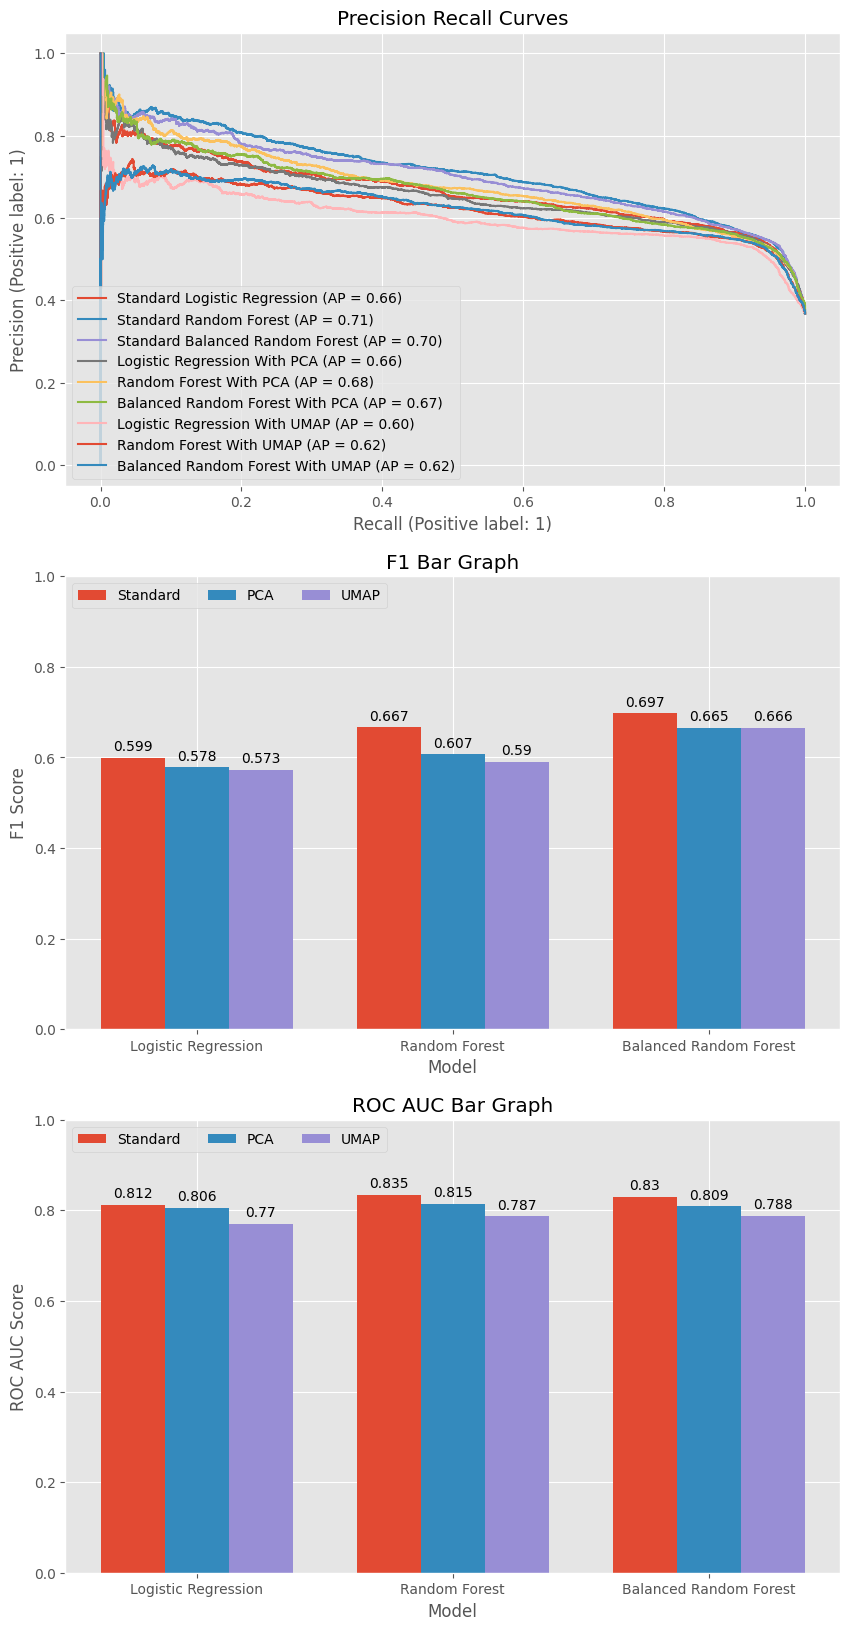

In [27]:
fig, axs = plt.subplots(3, figsize=(10, 20))
axs[0].set_title("Precision Recall Curves")
axs[1].set_title("F1 Bar Graph")
axs[1].set_xlabel('Model')
axs[1].set_ylabel('F1 Score')
axs[2].set_title("ROC AUC Bar Graph")
axs[2].set_xlabel('Model')
axs[2].set_ylabel('ROC AUC Score')

for model_name, vals in proba_aug.items():
  PrecisionRecallDisplay.from_predictions(y_test, vals, ax=axs[0], name=("Standard " + model_name))

for model_name, vals in proba_pca.items():
  PrecisionRecallDisplay.from_predictions(y_test, vals, ax=axs[0], name=(model_name + " With PCA"))

for model_name, vals in proba_umap.items():
  PrecisionRecallDisplay.from_predictions(y_test, vals, ax=axs[0], name=(model_name + " With UMAP"))

x = np.arange(len(list(models.keys())))
width = 0.25

rects = axs[1].bar(x - width, np.round(f1_aug, decimals=3), width, label=("Standard"))
axs[1].bar_label(rects, padding=3)

rects = axs[1].bar(x, np.round(f1_pca, decimals=3), width, label=("PCA"))
axs[1].bar_label(rects, padding=3)

rects = axs[1].bar(x + width, np.round(f1_umap, decimals=3), width, label=("UMAP"))
axs[1].bar_label(rects, padding=3)

axs[1].set_xticks(x, list(models.keys()))
axs[1].legend(loc='upper left', ncols=3)
axs[1].set_ylim(0, 1)


rects = axs[2].bar(x - width, np.round(roc_aug, decimals=3), width, label=("Standard"))
axs[2].bar_label(rects, padding=3)

rects = axs[2].bar(x, np.round(roc_pca, decimals=3), width, label=("PCA"))
axs[2].bar_label(rects, padding=3)

rects = axs[2].bar(x + width, np.round(roc_umap, decimals=3), width, label=("UMAP"))
axs[2].bar_label(rects, padding=3)

axs[2].set_xticks(x, list(models.keys()))
axs[2].legend(loc='upper left', ncols=3)
axs[2].set_ylim(0, 1)

plt.show()

Unfortunately, dimensionality reduction through PCA and UMAP did not improve the model. This is also logically consistent with statistical method #3 of the Exploratory Data Analysis section.

#### Stacking

An alternative way to improve model quality is through the ensemble method of [stacking](https://machinelearningmastery.com/stacking-ensemble-machine-learning-with-python/). This is an ML technique that best combines the predictions of multiple well-performing learning algorithms to optimize performance by combining the 'best traits' of each. For instance, the Random Forest classifier tends to have better precision for the non-smoking class, while the Balanced Random Forest Classifier tends to have better recall for the smoking class. So, I will stack all three models (Linear Regression, Random Forest, and Balanced Random Forest) for the standard dataset (with the added columns), the PCA dataset, and the UMAP dataset, and compare the results.

In [28]:
f1_stack_aug = []
roc_stack_aug = []
proba_stack_aug = {}

level0 = list()
level0.append(('LR', models['Logistic Regression']))
level0.append(('RF', models['Random Forest']))
level0.append(('BRF', models['Balanced Random Forest']))

level1 = LogisticRegression()
model = StackingClassifier(estimators=level0, final_estimator=level1, cv=5, n_jobs=-1)

model.fit(X_train_scaled, np.ravel(y_train))

y_pred = model.predict(X_test_scaled)
y_predict_proba = model.predict_proba(X_test_scaled)[:, 1]
proba_stack_aug["Augmented Stack"] = y_predict_proba

f1_stack_aug.append(f1_score(y_test, y_pred))
roc_stack_aug.append(roc_auc_score(y_test, y_predict_proba))

print("F1 Augmented Stack:", f1_score(y_test, y_pred))
print("ROC AUC Augmented Stack: ", roc_auc_score(y_test, y_predict_proba))
print(classification_report(y_test, y_pred, target_names=['Not smoker', 'Smoker']))

F1 Augmented Stack: 0.6660294920808302
ROC AUC Augmented Stack:  0.8349147809643493
              precision    recall  f1-score   support

  Not smoker       0.80      0.81      0.81      6347
      Smoker       0.67      0.66      0.67      3694

    accuracy                           0.76     10041
   macro avg       0.74      0.74      0.74     10041
weighted avg       0.76      0.76      0.76     10041



In [29]:
f1_stack_pca = []
roc_stack_pca = []
proba_stack_pca = {}

embedding = PCA(n_components=0.9, svd_solver='full', random_state=25)
embedding.fit(X_train_scaled)

X_train_scaled_transformed = embedding.transform(X_train_scaled)
X_test_scaled_transformed = embedding.transform(X_test_scaled)

model = StackingClassifier(estimators=level0, final_estimator=level1, cv=5)

model.fit(X_train_scaled_transformed, np.ravel(y_train))

y_pred = model.predict(X_test_scaled_transformed)
y_predict_proba = model.predict_proba(X_test_scaled_transformed)[:, 1]
proba_stack_pca["Stack with PCA"] = y_predict_proba

f1_stack_pca.append(f1_score(y_test, y_pred))
roc_stack_pca.append(roc_auc_score(y_test, y_predict_proba))

print("F1 Stack with PCA:", f1_score(y_test, y_pred))
print("ROC AUC Stack with PCA: ", roc_auc_score(y_test, y_predict_proba))
print(classification_report(y_test, y_pred, target_names=['Not smoker', 'Smoker']))

F1 Stack with PCA: 0.6249475010499791
ROC AUC Stack with PCA:  0.8152270481669694
              precision    recall  f1-score   support

  Not smoker       0.78      0.81      0.79      6347
      Smoker       0.65      0.60      0.62      3694

    accuracy                           0.73     10041
   macro avg       0.71      0.71      0.71     10041
weighted avg       0.73      0.73      0.73     10041



In [30]:
f1_stack_umap = []
roc_stack_umap = []
proba_stack_umap = {}

embedding = umap.UMAP(n_components=22, random_state=25)
embedding.fit(X_train_scaled)

X_train_scaled_transformed = embedding.transform(X_train_scaled)
X_test_scaled_transformed = embedding.transform(X_test_scaled)

model = StackingClassifier(estimators=level0, final_estimator=level1, cv=5)

model.fit(X_train_scaled_transformed, np.ravel(y_train))

y_pred = model.predict(X_test_scaled_transformed)
y_predict_proba = model.predict_proba(X_test_scaled_transformed)[:, 1]
proba_stack_umap["Stack with UMAP"] = y_predict_proba

f1_stack_umap.append(f1_score(y_test, y_pred))
roc_stack_umap.append(roc_auc_score(y_test, y_predict_proba))

print("F1 Stack with UMAP:", f1_score(y_test, y_pred))
print("ROC AUC Stack with UMAP:", roc_auc_score(y_test, y_predict_proba))
print(classification_report(y_test, y_pred, target_names=['Not smoker', 'Smoker']))

F1 Stack with UMAP: 0.5868517993765939
ROC AUC Stack with UMAP: 0.788844304771111
              precision    recall  f1-score   support

  Not smoker       0.76      0.80      0.78      6347
      Smoker       0.62      0.56      0.59      3694

    accuracy                           0.71     10041
   macro avg       0.69      0.68      0.68     10041
weighted avg       0.70      0.71      0.71     10041



To analyze how well these models do, I plot the results using three plots: a line graph containing the Precision-Recall Curve, a grouped bar chart for the F1 score, and a grouped bar chart for the ROC AUC score. Note that "LR" stands for Linear Regression, "RF" stands for Random Forest, and "BRF" stands for Balanced Random Forest.

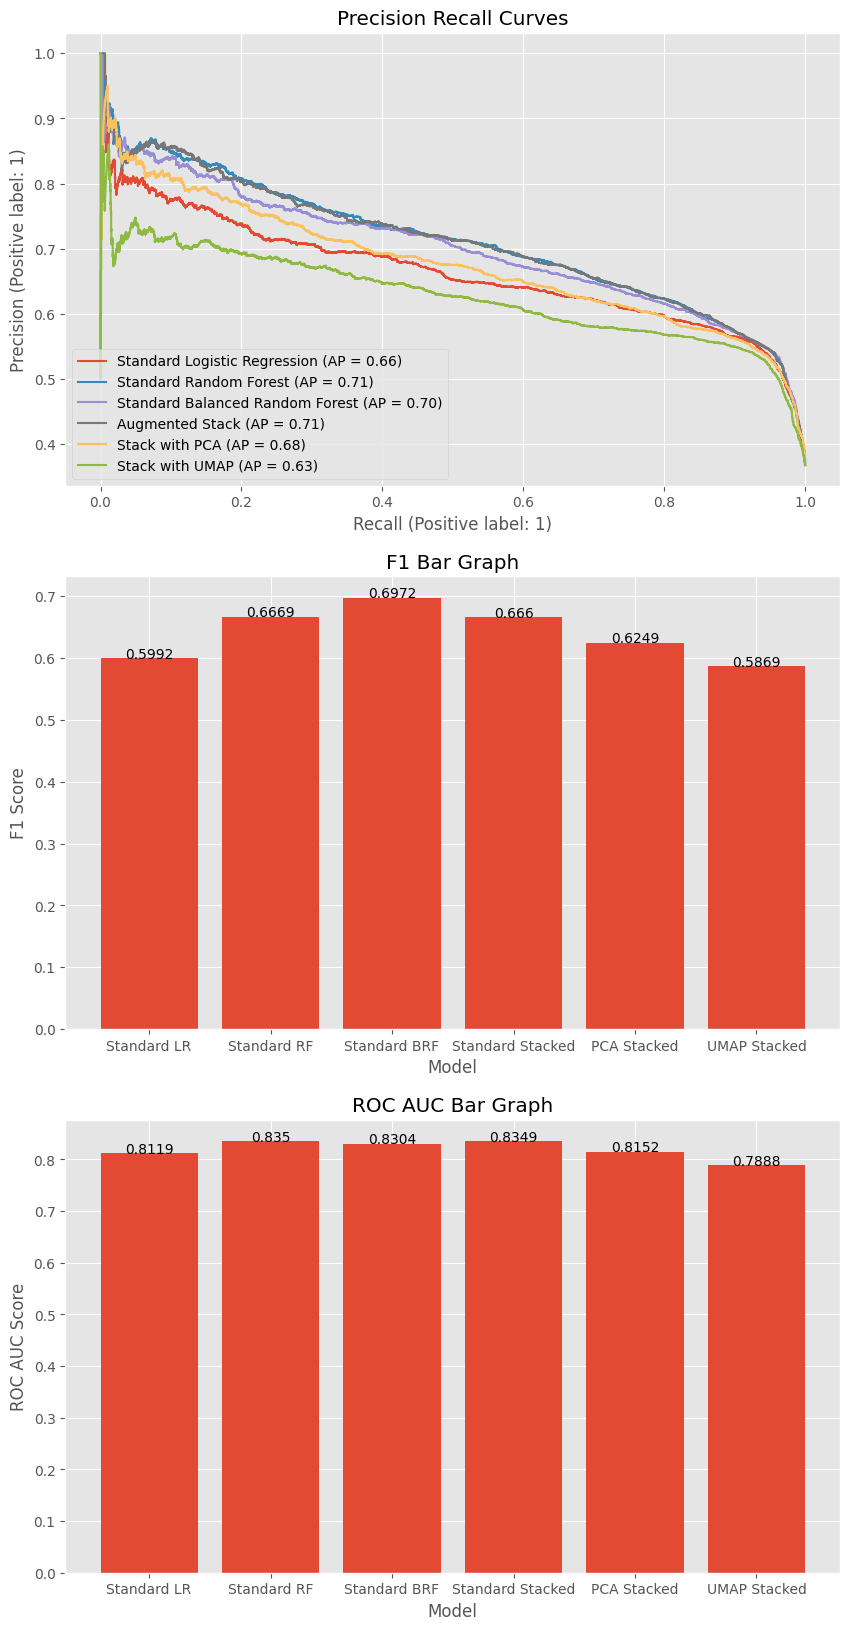

In [31]:
fig, axs = plt.subplots(3, figsize=(10, 20))
axs[0].set_title("Precision Recall Curves")
axs[1].set_title("F1 Bar Graph")
axs[1].set_xlabel('Model')
axs[1].set_ylabel('F1 Score')
axs[2].set_title("ROC AUC Bar Graph")
axs[2].set_xlabel('Model')
axs[2].set_ylabel('ROC AUC Score')

for model_name, vals in proba_aug.items():
  PrecisionRecallDisplay.from_predictions(y_test, vals, ax=axs[0], name=("Standard " + model_name))

for model_name, vals in proba_stack_aug.items():
  PrecisionRecallDisplay.from_predictions(y_test, vals, ax=axs[0], name=(model_name))

for model_name, vals in proba_stack_pca.items():
  PrecisionRecallDisplay.from_predictions(y_test, vals, ax=axs[0], name=(model_name))

for model_name, vals in proba_stack_umap.items():
  PrecisionRecallDisplay.from_predictions(y_test, vals, ax=axs[0], name=(model_name))

plt_models_f1 = {'Standard LR': f1_aug[0],
                 'Standard RF': f1_aug[1],
                 'Standard BRF': f1_aug[2],
                 'Standard Stacked': f1_stack_aug[0],
                 'PCA Stacked': f1_stack_pca[0],
                 'UMAP Stacked': f1_stack_umap[0]}

axs[1].bar(list(plt_models_f1.keys()), list(plt_models_f1.values()))

i = 0
for name, vals in plt_models_f1.items():
  axs[1].text(i, vals, round(vals, 4), ha = 'center')
  i += 1

plt_models_roc = {'Standard LR': roc_aug[0],
                 'Standard RF': roc_aug[1],
                 'Standard BRF': roc_aug[2],
                 'Standard Stacked': roc_stack_aug[0],
                 'PCA Stacked': roc_stack_pca[0],
                 'UMAP Stacked': roc_stack_umap[0]}

axs[2].bar(list(plt_models_roc.keys()), list(plt_models_roc.values()))

# for label in axs[1].get_xticklabels() + axs[2].get_xticklabels():
#   label.set_rotation(15)
#   label.set_ha('right')

i = 0
for name, vals in plt_models_roc.items():
  axs[2].text(i, vals, round(vals, 4), ha = 'center')
  i += 1

plt.show()

The stacked model on the standard dataset performs approximately equally as well as the Standard Balanced Random Forest implementation. However, training a stacked model is significantly more computationally expensive, because it requires training all the input models with cross validation as well. So, the Standard Balanced Random Forest implementation is still the best usable ML model, out of all the models attempted thus far.

### Clustering

In addition to the supervised learning dataset, the Kaggle repository also contained a dataset that did not have a column for the target vector (smoking). Since this dataset shows the same trends as the supervised learning dataset (as per statistical method #3 in the Exploratory Data Analysis section), I decided to put this data to use for clustering.

In clustering, data instances are grouped together such that all instances in the same cluster are similar to each other and very different from all instances in different clusters. This is an unsupervised learning algorithm, and does not use the target variable, so I decided to combine the supervised and unsupervised learning datasets (excluding the smoking column) to train the clustering algorithm that I am using: K-Means.
* In [K-Means](https://www.geeksforgeeks.org/k-means-clustering-introduction/), $k$ centroid centers are chosen at random positions in the sample space, each data instance is iteratively assigned to the nearest cluster, and the centroid positions are updated until the positions converge. $k$ is a hyperparameter and there are multiple ways to choose it. I use a combination of the [Elbow Method](https://www.geeksforgeeks.org/elbow-method-for-optimal-value-of-k-in-kmeans/) and the [Silhouette Method](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html). In the Elbow method, the optimal value of $k$ is chosen to be where the change in WCSS (Within Cluster Sum of Squares, aka intracluster variance) changes from a large negative value to a small negative value. However, for this dataset, the 'elbow' was not very distinguishable, so I used the Silhouette method as well. This method analyzes the separation distance between an arbitrary point and the points in the neighboring clusters, and states to choose the value of $k$ where this separation distance is largest.

Here, I form a dataframe that combines all the data from the supervised and unsupervised learning datasets. There are guaranteed to be no repeating data instances because I removed all duplicated rows earlier in the tutorial.

In [32]:
total_unsup_df = pd.concat([sup_df, unsup_df])
del total_unsup_df['smoking']
print(total_unsup_df.shape)

(44552, 26)


Here, I iteratively determine the best value of $k$ for this dataset, which turns out to be 3, using the Elbow and Silhouette Methods.

In [33]:
scaler = StandardScaler()
total_scaled = scaler.fit_transform(total_unsup_df)
sup_df_scaled = scaler.transform(sup_df.loc[:, sup_df.columns != 'smoking'])

# wcss = []
# sil = []
# for i in range(2, 50):
#   model = KMeans(n_clusters=i, random_state=25)
#   model.fit(total_scaled)
#   wcss.append(model.inertia_)
#   sil.append(silhouette_score(total_scaled, model.labels_, metric = 'euclidean'))

#   print("i:", i, "\tWCSS: ", model.inertia_)

I plot the results of the iterative process to apply the Elbow Method, although the 'elbow' is not very clear.

In [34]:
# xs = [(x + 2) for x in range(len(wcss))]
# plt.plot(xs, wcss)
# plt.show()

I plot the results of the Silhouette Method for each $k$, and the absolute max is at $k = 3$. As a result, this will be the chosen value for the $k$ hyperparameter.

In [35]:
# plt.plot(xs, sil)
# plt.show()

Now that we have this clustered model, we can apply it to the supervised learning dataset to extract more insights. So, I use the K-Means model to predict the cluster value of each data instance in the supervised learning dataset, and concat it with the results to form $\verb|clustered_sup_df|$. This is so I can easily filter data instances by which cluster they are in.

In [36]:
model = KMeans(n_clusters=3, random_state=25)
model.fit(total_scaled)

result = model.predict(sup_df_scaled)

sup_df.reset_index(inplace=True)

ser = pd.Series(result, name='Cluster')

clustered_sup_df = pd.concat([sup_df, ser], axis=1)
clustered_sup_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33467 entries, 0 to 33466
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   index                33467 non-null  int64  
 1   age                  33467 non-null  int64  
 2   height(cm)           33467 non-null  int64  
 3   weight(kg)           33467 non-null  int64  
 4   waist(cm)            33467 non-null  float64
 5   eyesight(left)       33467 non-null  float64
 6   eyesight(right)      33467 non-null  float64
 7   hearing(left)        33467 non-null  int64  
 8   hearing(right)       33467 non-null  int64  
 9   systolic             33467 non-null  int64  
 10  relaxation           33467 non-null  int64  
 11  fasting blood sugar  33467 non-null  int64  
 12  Cholesterol          33467 non-null  int64  
 13  triglyceride         33467 non-null  int64  
 14  HDL                  33467 non-null  int64  
 15  LDL                  33467 non-null 

Here, we wish to gain insight on the clustering.

In [37]:
for i in range(0, 3):
  print("Cluster:", i)

  rows = clustered_sup_df[clustered_sup_df['Cluster'] == i]
  print("Number of rows in this cluster:", len(rows))
  print("Number of non-smokers in this cluster:", rows[rows['smoking'] == 0]['smoking'].count())
  print("Number of smokers in this cluster:", rows[rows['smoking'] == 1]['smoking'].count())

  center = model.cluster_centers_[i].reshape(1, -1)
  readable_center = scaler.inverse_transform(center)
  np.set_printoptions(precision = 2, suppress = True)
  print(readable_center, "\n\n")

Cluster: 0
Number of rows in this cluster: 1256
Number of non-smokers in this cluster: 862
Number of smokers in this cluster: 394
[[ 58.82 160.35  61.77  83.04   0.86   0.87   1.67   1.68 125.65  76.37
  104.41 192.19 127.7   55.67 111.25  14.35   1.11   0.89  27.19  25.93
   42.52   0.17  23.95  49.28   0.57   1.27]] 


Cluster: 1
Number of rows in this cluster: 16435
Number of non-smokers in this cluster: 7808
Number of smokers in this cluster: 8627
[[ 40.86 169.85  75.22  87.97   1.07   1.07   1.     1.   125.79  79.14
  102.96 200.17 156.86  51.43 118.51  15.5    1.1    0.97  29.09  35.29
   54.65   0.25  26.08  46.64   0.48   0.94]] 


Cluster: 2
Number of rows in this cluster: 15776
Number of non-smokers in this cluster: 12539
Number of smokers in this cluster: 3237
[[ 46.5  159.63  56.54  75.9    0.96   0.95   1.     1.   116.79  72.81
   95.15 194.09  95.45  63.49 111.75  13.74   1.07   0.8   23.16  18.69
   24.78   0.18  22.21  43.98   0.64   1.36]] 




This clustering results some interesting results:
* In cluster 0, 31.4% of the data instances correspond to people who smoke.
* In cluster 1, over half of the data instances correspond to people who smoke.
* The people in cluster 1 tend to have the highest cholesterol, triglyceride, LDL, hemoglobin, serum creatinine, AST, ALT, GTP, number of cavities, BMI, and the lowest HDL, HDL-LDL, and Liver Enzyme ratios. Research has linked all of these biosignals have been linked to smoking, which explains why so many people in this cluster are smokers. However, since 48.5% of this group doesn't smoke, it is possible that this cluster contains the people who have other health issues that emulate the biosignals of smokers. One potential example is obesity, which is well known to cause high cholesterol and triglyceride levels, along with other changed biosignals.
* In cluster 2, 20.5% of the data instances correspond to people who smoke.

Logically, the next step is to train ML models on each of these clusters to see if there is any improvement in model performance.

In [38]:
f1_orig = []
roc_orig = []
f1_clu = []
roc_clu = []

for i in range(0, 3):
  rows = clustered_sup_df[clustered_sup_df['Cluster'] == i]
  print("Cluster:", i, "\tNumber of rows:", len(rows))

  X_train, X_test, y_train, y_test = train_test_split(
      rows.loc[:, (rows.columns !='smoking') & (rows.columns != 'Cluster')],
      rows['smoking'], test_size=0.30, random_state=25)

  scaler = StandardScaler()
  X_train_scaled = scaler.fit_transform(X_train)
  X_test_scaled = scaler.transform(X_test)

  for model_name, model in models.items():
    model.fit(X_train_scaled, np.ravel(y_train))

  f1_temp = []
  roc_temp = []
  for model_name, model in models.items():
    y_pred = model.predict(X_test_scaled)
    y_predict_proba = model.predict_proba(X_test_scaled)[:, 1]

    f1_temp.append(f1_score(y_test, y_pred))
    roc_temp.append(roc_auc_score(y_test, y_predict_proba))

    f1_orig.append(f1_score(y_test, models_aug[model_name].predict(X_test_scaled)))
    roc_orig.append(roc_auc_score(y_test, models_aug[model_name].predict_proba(X_test_scaled)[:, 1]))

    print("F1 Cluster", i, ":", f1_score(y_test, y_pred))
    print("ROC AUC Cluster", i, ":", roc_auc_score(y_test, y_predict_proba))
    print(classification_report(y_test, y_pred, target_names=['Not smoker', 'Smoker']))

    print("\n")

  f1_clu.append(f1_temp)
  roc_clu.append(roc_temp)

Cluster: 0 	Number of rows: 1256
F1 Cluster 0 : 0.5333333333333333
ROC AUC Cluster 0 : 0.7903408711893803
              precision    recall  f1-score   support

  Not smoker       0.79      0.85      0.82       263
      Smoker       0.58      0.49      0.53       114

    accuracy                           0.74       377
   macro avg       0.69      0.67      0.68       377
weighted avg       0.73      0.74      0.73       377



F1 Cluster 0 : 0.5258215962441315
ROC AUC Cluster 0 : 0.7956440530985258
              precision    recall  f1-score   support

  Not smoker       0.79      0.84      0.81       263
      Smoker       0.57      0.49      0.53       114

    accuracy                           0.73       377
   macro avg       0.68      0.66      0.67       377
weighted avg       0.72      0.73      0.73       377



F1 Cluster 0 : 0.5504587155963302
ROC AUC Cluster 0 : 0.79280901874458
              precision    recall  f1-score   support

  Not smoker       0.80      0.83    

To better understand the numbers above, we plot the Grouped Bar graphs of the F1 score and ROC AUC score. The Precision-Recall Curve is not plotted because there are too many lines (18) for any to be understandable.

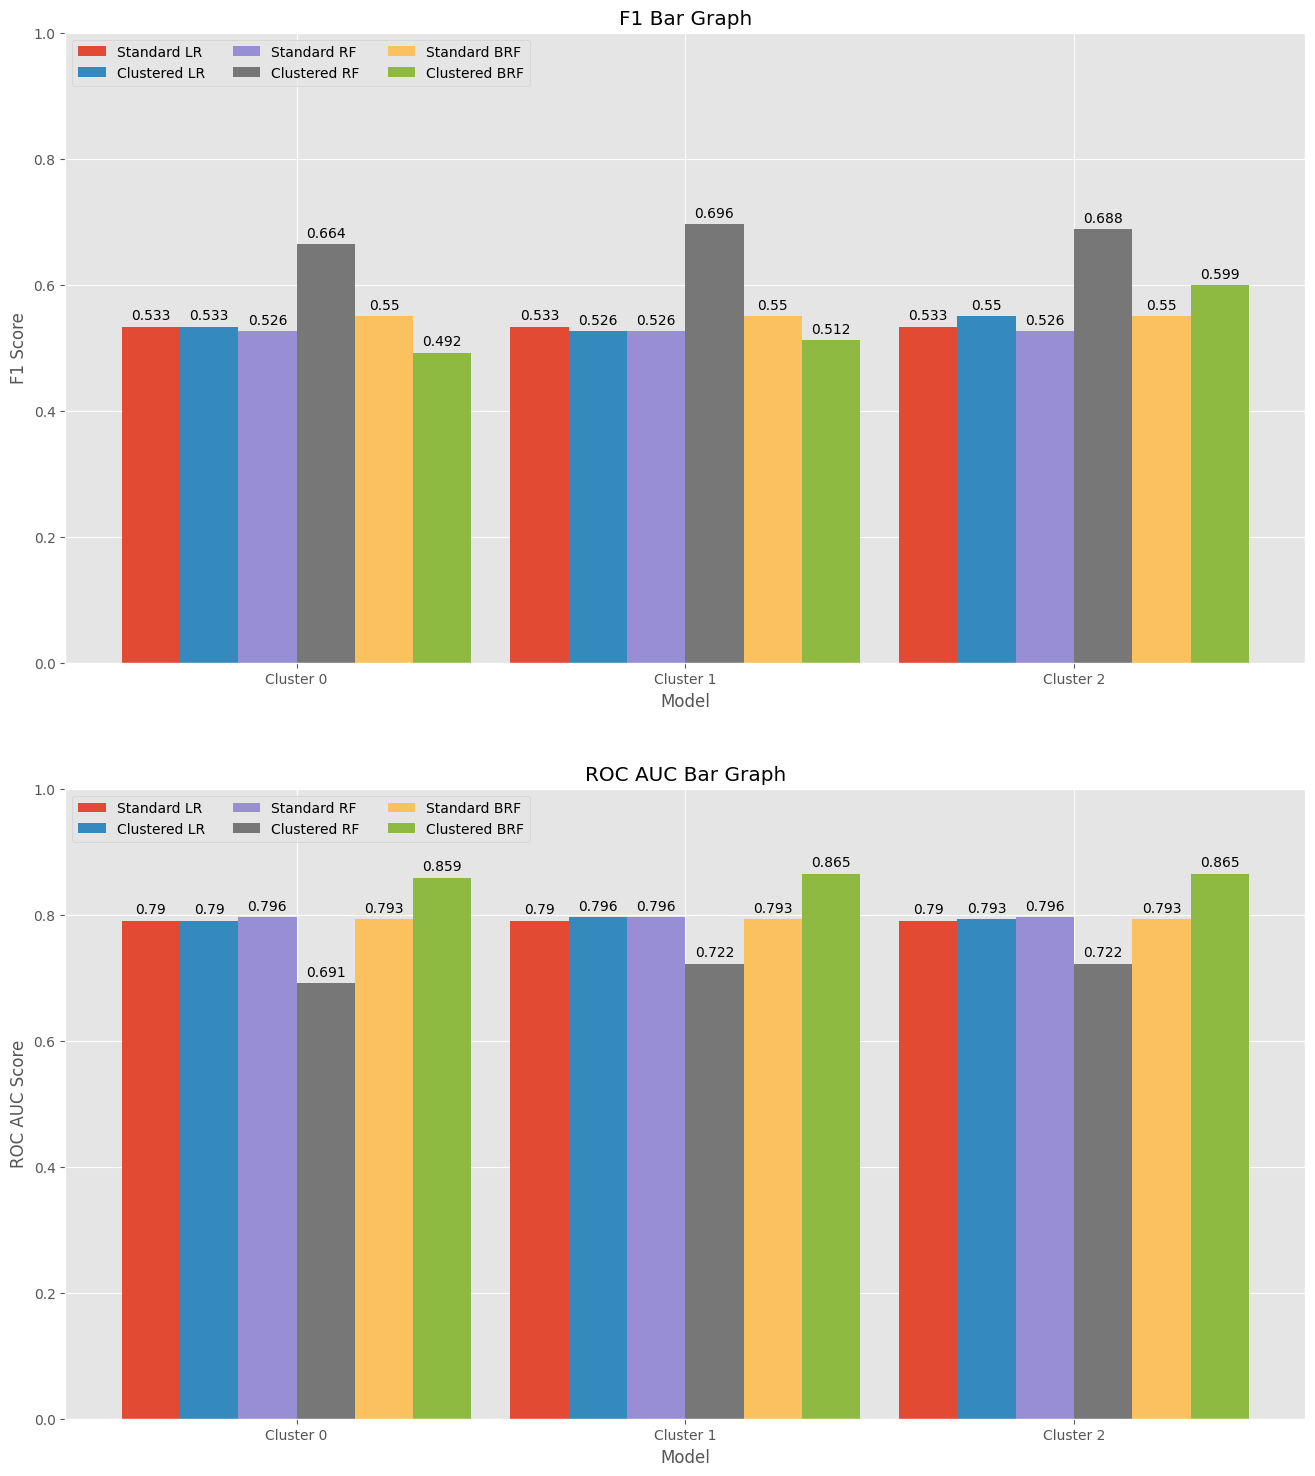

In [39]:
fig, axs = plt.subplots(2, figsize=(16, 18))
axs[0].set_title("F1 Bar Graph")
axs[0].set_xlabel('Model')
axs[0].set_ylabel('F1 Score')
axs[1].set_title("ROC AUC Bar Graph")
axs[1].set_xlabel('Model')
axs[1].set_ylabel('ROC AUC Score')

x = np.arange(len(list(models.keys())))
width = 0.15

rects = axs[0].bar(x - (3*width), np.round(f1_orig[0], decimals=3), width, label=("Standard LR"))
axs[0].bar_label(rects, padding=3)

rects = axs[0].bar(x - (2*width), np.round(f1_clu[0], decimals=3), width, label=("Clustered LR"))
axs[0].bar_label(rects, padding=3)

rects = axs[0].bar(x - width, np.round(f1_orig[1], decimals=3), width, label=("Standard RF"))
axs[0].bar_label(rects, padding=3)

rects = axs[0].bar(x, np.round(f1_clu[1], decimals=3), width, label=("Clustered RF"))
axs[0].bar_label(rects, padding=3)

rects = axs[0].bar(x + width, np.round(f1_orig[2], decimals=3), width, label=("Standard BRF"))
axs[0].bar_label(rects, padding=3)

rects = axs[0].bar(x + (2*width), np.round(f1_clu[2], decimals=3), width, label=("Clustered BRF"))
axs[0].bar_label(rects, padding=3)

axs[0].set_xticks(x - (width / 2), ['Cluster 0', 'Cluster 1', 'Cluster 2'])
axs[0].legend(loc='upper left', ncols=3)
axs[0].set_ylim(0, 1)


rects = axs[1].bar(x - (3*width), np.round(roc_orig[0], decimals=3), width, label=("Standard LR"))
axs[1].bar_label(rects, padding=3)

rects = axs[1].bar(x - (2*width), np.round(roc_clu[0], decimals=3), width, label=("Clustered LR"))
axs[1].bar_label(rects, padding=3)

rects = axs[1].bar(x - width, np.round(roc_orig[1], decimals=3), width, label=("Standard RF"))
axs[1].bar_label(rects, padding=3)

rects = axs[1].bar(x, np.round(roc_clu[1], decimals=3), width, label=("Clustered RF"))
axs[1].bar_label(rects, padding=3)

rects = axs[1].bar(x + width, np.round(roc_orig[2], decimals=3), width, label=("Standard BRF"))
axs[1].bar_label(rects, padding=3)

rects = axs[1].bar(x + (2*width), np.round(roc_clu[2], decimals=3), width, label=("Clustered BRF"))
axs[1].bar_label(rects, padding=3)

axs[1].set_xticks(x - (width / 2), ['Cluster 0', 'Cluster 1', 'Cluster 2'])
axs[1].legend(loc='upper left', ncols=3)
axs[1].set_ylim(0, 1)

plt.show()

Based on the F1 values, which are more robust to unbalanced datasets than ROC-AUC values, the Random Forest Classifier that was trained on each cluster specifically (Clustered RF) performs significantly better than the other models for data within that cluster. This suggests that out of the ML pipelines discussed in this tutorial, the one with the best performance involves clustering the dataset, and training a Random Forest model on each cluster.

## Final Thoughts
As seen over the course of this tutorial, predicting if someone smokes, from biosignals alone, is a challenging problem. This is especially because as established by research, statistical tests, and the results of these ML models, a lot of factors are statistically significantly affected by smoking, but the change in their biosignals doesn't imply that they are smokers. Moreover, research has found that healthy levels of some biosignals (such as hemoglobin) differs between biological males and females, but this dataset doesn't account for that. So, to more accurately predict the smoker attribute, one would need to account for the person's biological sex, along with potentially other important factors like socioeconomic status or if they are suffering from substance use or mental illness disorders.

Despite these challenges, I developed a ML pipeline that predicts smoking status with relatively high robustness. This pipeline involves determining the data instance's cluster, and using the Random Forest Classifier model for that specific cluster to predict the target attribute. In the future, many adjustments can be made to improve the model. Dimensionality reduction could be performed on the individual clusters, or different sets of classifiers could be combined through the stacking ensemble technique. Different dimensionality reduction or clustering algorithms, or deep learning models could be attempted. Outliers could be removed more rigorously. This tutorial may not have answered the question of what ML pipeline is objectively the best for this dataset, but we have taken a large leap forward by experimenting with some ML models and establishing some of the endless possibilities for improvement. Hopefully, these insights (although not groundbreaking) can help doctors better determine if someone is smoking, and early, to decrease the economical ramifications of a smoking-related illness.